In [1]:
import tensorflow as tf
print (tf.test.gpu_device_name())

/device:GPU:0


In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple
  Running setup.py bdist_wheel for kaggle ... - done
  Stored in directory: /content/.cache/pip/wheels/dc/03/02/372e828042d91dc9d96c6d5eab5b14591790dafe70600b7309
Successfully built kaggle


In [3]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [4]:
!kaggle datasets download -d 'uciml/sms-spam-collection-dataset'

In [7]:
!ls -alh .kaggle/datasets/uciml/sms-spam-collection-dataset/

total 708K
drwxr-xr-x 2 root root 4.0K Apr 28 11:25 .
drwxr-xr-x 3 root root 4.0K Apr 28 11:25 ..
-rw-r--r-- 1 root root 208K Apr 28 11:25 sms-spam-collection-dataset.zip
-rw-r--r-- 1 root root 492K Apr 28 11:25 spam.csv


## First Implementation

In [0]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import nltk

%matplotlib inline

In [10]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /content/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /content/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /content/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /content/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     /content/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /content/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /content/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /c

[nltk_data]    | Downloading package nps_chat to /content/nltk_data...
[nltk_data]    |   Unzipping corpora/nps_chat.zip.
[nltk_data]    | Downloading package omw to /content/nltk_data...
[nltk_data]    |   Unzipping corpora/omw.zip.
[nltk_data]    | Downloading package opinion_lexicon to
[nltk_data]    |     /content/nltk_data...
[nltk_data]    |   Unzipping corpora/opinion_lexicon.zip.
[nltk_data]    | Downloading package paradigms to
[nltk_data]    |     /content/nltk_data...
[nltk_data]    |   Unzipping corpora/paradigms.zip.
[nltk_data]    | Downloading package pil to /content/nltk_data...
[nltk_data]    |   Unzipping corpora/pil.zip.
[nltk_data]    | Downloading package pl196x to /content/nltk_data...
[nltk_data]    |   Unzipping corpora/pl196x.zip.
[nltk_data]    | Downloading package ppattach to /content/nltk_data...
[nltk_data]    |   Unzipping corpora/ppattach.zip.
[nltk_data]    | Downloading package problem_reports to
[nltk_data]    |     /content/nltk_data...
[nltk_data]  

[nltk_data]    | Downloading package words to /content/nltk_data...
[nltk_data]    |   Unzipping corpora/words.zip.
[nltk_data]    | Downloading package ycoe to /content/nltk_data...
[nltk_data]    |   Unzipping corpora/ycoe.zip.
[nltk_data]    | Downloading package rslp to /content/nltk_data...
[nltk_data]    |   Unzipping stemmers/rslp.zip.
[nltk_data]    | Downloading package maxent_treebank_pos_tagger to
[nltk_data]    |     /content/nltk_data...
[nltk_data]    |   Unzipping taggers/maxent_treebank_pos_tagger.zip.
[nltk_data]    | Downloading package universal_tagset to
[nltk_data]    |     /content/nltk_data...
[nltk_data]    |   Unzipping taggers/universal_tagset.zip.
[nltk_data]    | Downloading package maxent_ne_chunker to
[nltk_data]    |     /content/nltk_data...
[nltk_data]    |   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data]    | Downloading package punkt to /content/nltk_data...
[nltk_data]    |   Unzipping tokenizers/punkt.zip.
[nltk_data]    | Downloading package

True

In [11]:
# read in the data from csv file
sms = pd.read_csv('.kaggle/datasets/uciml/sms-spam-collection-dataset/spam.csv', encoding='latin-1')
sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [0]:
# Drop unnamed columns and rename v1 and v2 as `label` and `message`
sms = sms.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
sms = sms.rename(columns={'v1': 'label', 'v2': 'message'})

In [13]:
# data summary
sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [14]:
 # new feature, `message_length` and plot to see if of any interest
  sms['length'] = sms['message'].apply(len)
  sms.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9759cdabe0>,
      dtype=object)

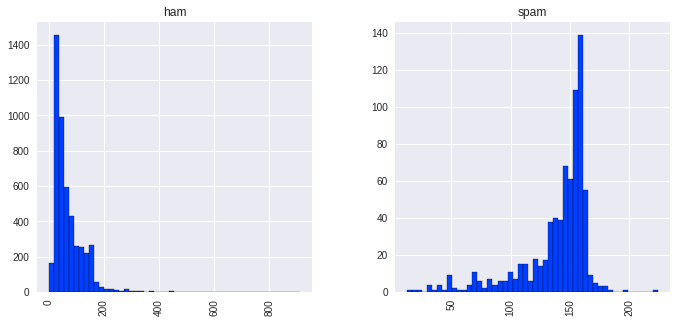

In [15]:
mpl.rcParams['patch.force_edgecolor'] = True
plt.style.use('seaborn-bright')
sms.hist(column='length', by='label', bins=50, figsize=(11,5))

### Looks like the lengthy is the message, more likely it is a spam. Let's not forget this

### Text processing and vectorizing our meddages

In [0]:
# create new dataframe, we'll need a copy later
text_feat = sms['message'].copy()

In [0]:
# Now define text preprocessing function. It will remove any punctuation and stopwords as well.

def text_process(text):
  text = text.translate(str.maketrans('', '', string.punctuation))
  text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
  
  return ' '.join(text)

In [0]:
text_feat = text_feat.apply(text_process)

In [0]:
vectorizer = TfidfVectorizer('english')

In [0]:
features = vectorizer.fit_transform(text_feat)

### Classifiers and predictions

In [0]:
# split data
features_train, features_test, labels_train, labels_test = train_test_split(features, sms['label'], test_size=0.3, random_state=111)

In [0]:
# Import a bunch of classifier, initialize and make a dict to iterate through

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score

In [0]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)
abc = AdaBoostClassifier(n_estimators=62, random_state=111)
bc = BaggingClassifier(n_estimators=9, random_state=111)
etc = ExtraTreesClassifier(n_estimators=9, random_state=111)

In [0]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc}

In [0]:
# fn to fit our classifiers and make predictions

def train_classifier(clf, feature_train, labels_train):
  clf.fit(features_train, labels_train)

In [0]:
def predict_labels(clf, features):
  return (clf.predict(features))

In [0]:
# iterate through classifiers and save results

pred_scores = []

for k,v in clfs.items():
  train_classifier(v, features_train, labels_train)
  pred = predict_labels(v, features_test)
  pred_scores.append((k, [accuracy_score(labels_test, pred)]))

In [29]:
df = pd.DataFrame.from_items(pred_scores, orient='index', columns=['Score'])
df

,Score
SVC,0.978469
KN,0.924641
NB,0.984450
DT,0.958732
LR,0.943182
RF,0.970096
AdaBoost,0.967105
BgC,0.967105
ETC,0.977273


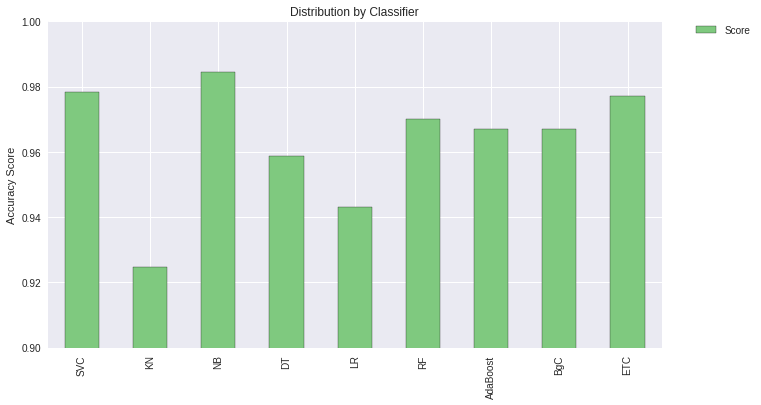

In [30]:
df.plot(kind='bar', ylim=(0.9,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Stemmer - It is said that stemming short messages does no good or even harm predictions. Let's try this out.

In [0]:
# define stemmer fn
def stemmer(text):
  text = text.split()
  words = ""
  for i in text:
    stemmer = SnowballStemmer('english')
    words += (stemmer.stem(i)) + ' '
  return words

In [0]:
text_feat = text_feat.apply(stemmer)

In [0]:
features = vectorizer.fit_transform(text_feat)

In [0]:
features_train, features_test, labels_train, labels_test = train_test_split(features, sms['label'], test_size=0.3, random_state=111)

In [0]:
pred_scores = []

for k, v in clfs.items():
  train_classifier(v, features_train, labels_train)
  pred = predict_labels(v, features_test)
  pred_scores.append((k, [accuracy_score(labels_test, pred)]))

In [36]:
df2 = pd.DataFrame.from_items(pred_scores, orient='index', columns=['Score2'])
df = pd.concat([df, df2], axis=1)
df

,Score,Score2
SVC,0.978469,0.978469
KN,0.924641,0.928230
NB,0.984450,0.985048
DT,0.958732,0.959928
LR,0.943182,0.946770
RF,0.970096,0.974880
AdaBoost,0.967105,0.970096
BgC,0.967105,0.968900
ETC,0.977273,0.977871


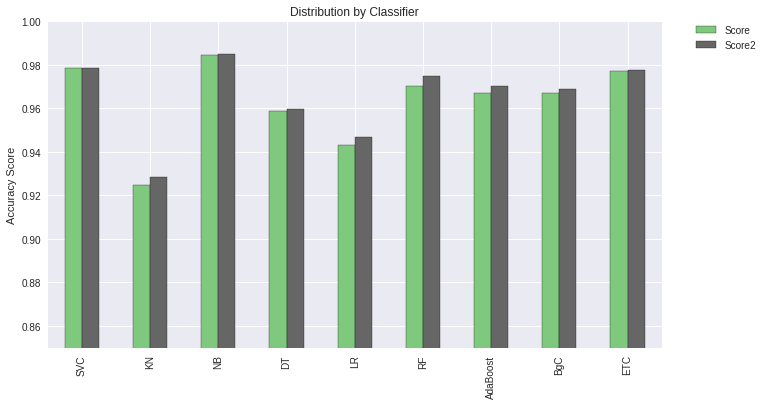

In [37]:
df.plot(kind='bar', ylim=(0.85,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [0]:
# Above looks almost same
# Let's append our message length feature to the matrix we fit into our classifiers

In [0]:
lf = sms['length'].as_matrix()
newfeat = np.hstack((features.todense(), lf[:, None]))

In [0]:
features_train, features_test, labels_train, labels_test = train_test_split(newfeat, sms['label'], test_size=0.3, random_state=111)

In [0]:
pred_scores = []

for k, v in clfs.items():
  train_classifier(v, features_train, labels_train)
  pred = predict_labels(v, features_test)
  pred_scores.append((k, [accuracy_score(labels_test, pred)]))

In [42]:
df3 = pd.DataFrame.from_items(pred_scores, orient='index', columns=['Score3'])
df = pd.concat([df, df3], axis=1)
df

,Score,Score2,Score3
SVC,0.978469,0.978469,0.861244
KN,0.924641,0.928230,0.880383
NB,0.984450,0.985048,0.982656
DT,0.958732,0.959928,0.957536
LR,0.943182,0.946770,0.954545
RF,0.970096,0.974880,0.975478
AdaBoost,0.967105,0.970096,0.961722
BgC,0.967105,0.968900,0.962321
ETC,0.977273,0.977871,0.975478


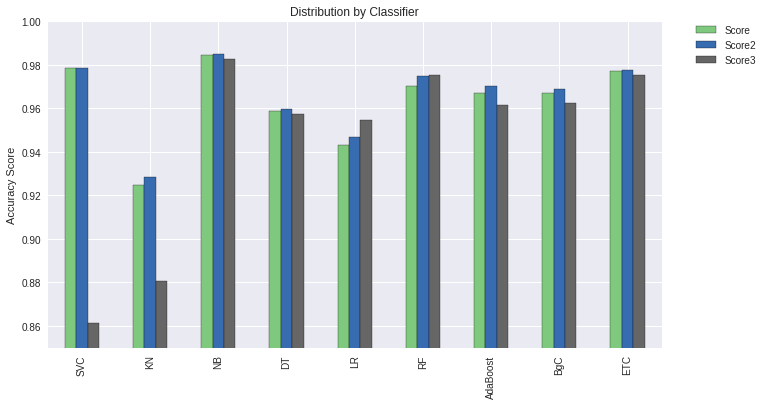

In [43]:
df.plot(kind='bar', ylim=(0.85,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [0]:
# Voting classifier
from sklearn.ensemble import VotingClassifier

In [0]:
eclf = VotingClassifier(estimators=[('BgC', bc), ('ETC', etc), ('RF', rfc), ('Ada', abc)], voting='soft')

In [46]:
eclf.fit(features_train,labels_train)

VotingClassifier(estimators=[('BgC', BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=9, n_jobs=1, oob_score=False, random_state=111,
         verbose=0, warm_start=False)), ('ETC', ExtraTreesClassifier(bootstrap=False,...hm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=62, random_state=111))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [47]:
pred = eclf.predict(features_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [48]:
print(accuracy_score(labels_test,pred))

0.979066985645933


## Final - Seems NaiveBayes Classifier is the winner